In [1]:
import nbimporter
from data_loader import load_data
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

c:\Users\Nouran\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
IMG_SIZE = (299, 299)  # InceptionV3 uses 299x299 input size
BATCH_SIZE = 64
EPOCHS = 50

In [4]:
# Load data
train_gen, val_gen, test_gen,_ = load_data(
    train_path="C:/Users/Nouran/.cache/kagglehub/datasets/gpiosenka/musical-instruments-image-classification/versions/1/train",
    valid_path="C:/Users/Nouran/.cache/kagglehub/datasets/gpiosenka/musical-instruments-image-classification/versions/1/valid",
    test_path="C:/Users/Nouran/.cache/kagglehub/datasets/gpiosenka/musical-instruments-image-classification/versions/1/test",
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=42
)

Found 4793 images belonging to 30 classes.
Found 150 images belonging to 30 classes.
Found 150 images belonging to 30 classes.


In [5]:
NUM_CLASSES = len(train_gen.class_indices)
print(f"Number of classes: {NUM_CLASSES}")

Number of classes: 30


In [6]:
# Load InceptionV3 base model
base_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

In [7]:
# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

In [8]:
# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

In [9]:
# Build final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 24,441,150 (93.24 MB)

 Trainable params: 2,638,366 (10.06 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [10]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

In [11]:

# Train
history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // BATCH_SIZE,
    validation_data=val_gen,
    validation_steps=val_gen.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks
)

C:\Users\Nouran\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 561s 7s/step - accuracy: 0.2284 - loss: 2.9626 - val_accuracy: 0.8984 - val_loss: 0.9448 - learning_rate: 1.0000e-04
Epoch 2/50
 1/74 ━━━━━━━━━━━━━━━━━━━━ 5:03 4s/step - accuracy: 0.6250 - loss: 1.2887

C:\Users\Nouran\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


74/74 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 0.6250 - loss: 1.2887 - val_accuracy: 0.8984 - val_loss: 0.9251 - learning_rate: 1.0000e-04
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 497s 7s/step - accuracy: 0.7221 - loss: 1.1551 - val_accuracy: 0.9453 - val_loss: 0.3035 - learning_rate: 1.0000e-04
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy: 0.7500 - loss: 0.8508 - val_accuracy: 0.9531 - val_loss: 0.3020 - learning_rate: 1.0000e-04
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 490s 7s/step - accuracy: 0.8095 - loss: 0.6859 - val_accuracy: 0.9688 - val_loss: 0.1825 - learning_rate: 1.0000e-04
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 0.8750 - loss: 0.4212 - val_accuracy: 0.9688 - val_loss: 0.1800 - learning_rate: 1.0000e-04
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 551s 7s/step - accuracy: 0.8474 - loss: 0.5193 - val_accuracy: 0.9609 - val_loss: 0.1450 - learning_rate: 1.0000e-04
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 0.8281 - l

In [13]:
# Evaluate
test_loss, test_acc = model.evaluate(test_gen)
print(f"\nTest Accuracy: {test_acc * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9802 - loss: 0.0466

Test Accuracy: 98.00%


3/3 ━━━━━━━━━━━━━━━━━━━━ 33s 8s/step


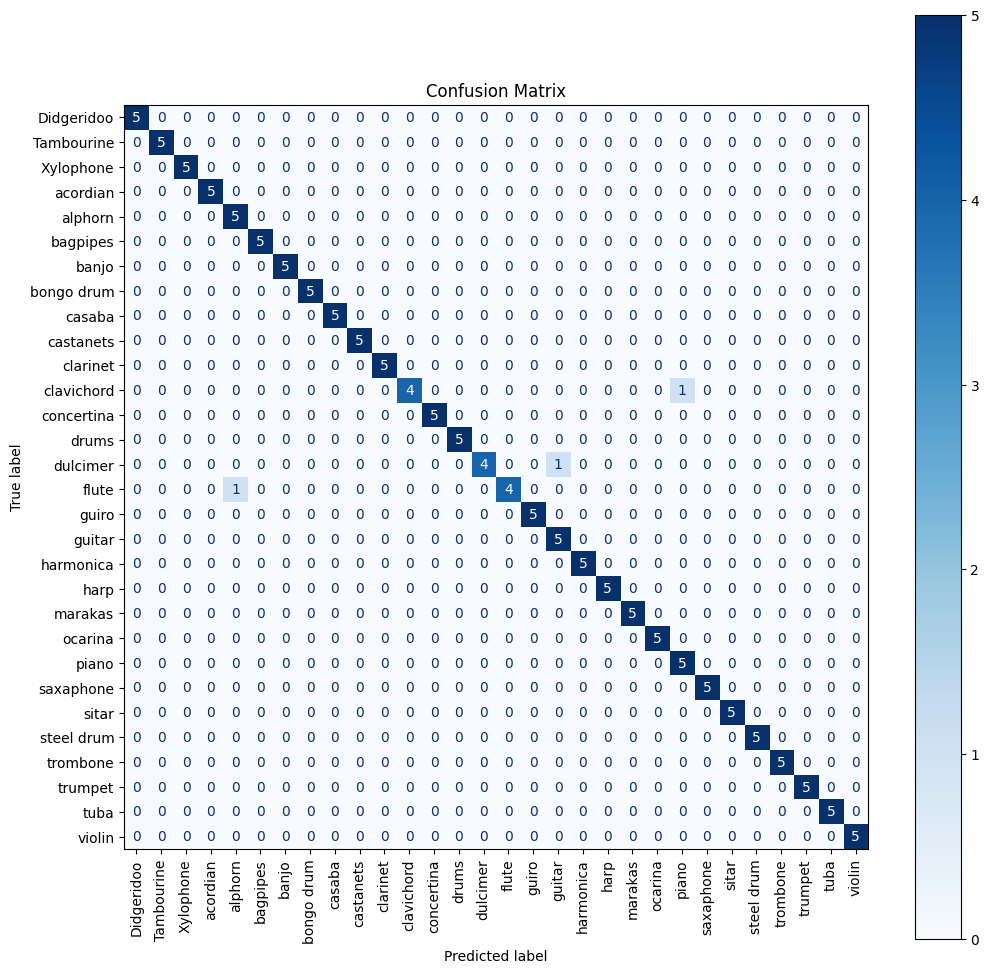

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true labels and predictions for the test set
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = list(test_gen.class_indices.keys())

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

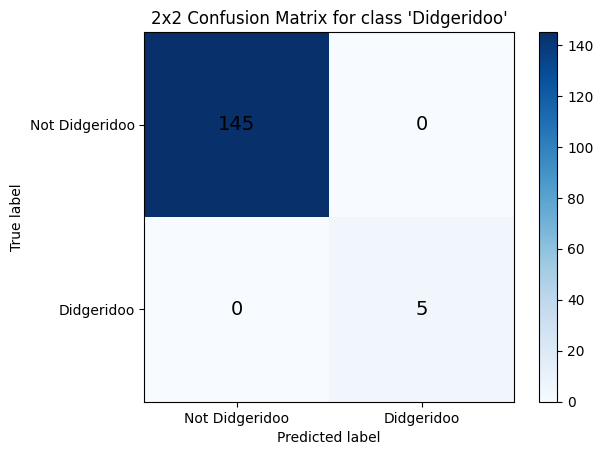

In [51]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
im = ax.imshow(cm_2x2, cmap='Blues')

# Show all ticks and label them
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Not ' + class_names[target_class_idx], class_names[target_class_idx]])
ax.set_yticklabels(['Not ' + class_names[target_class_idx], class_names[target_class_idx]])

# Label axes
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title(f"2x2 Confusion Matrix for class '{class_names[target_class_idx]}'")

# Annotate cells
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm_2x2[i, j], ha='center', va='center', color='black', fontsize=14)

plt.colorbar(im, ax=ax)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


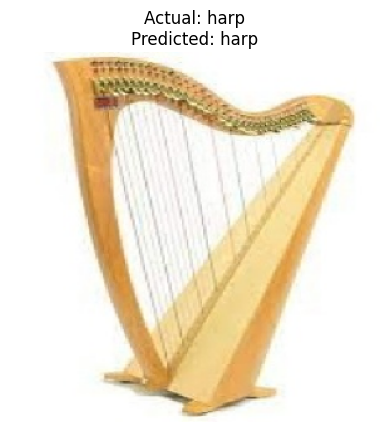

In [39]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

def test_random_image(model, test_gen, img_size=(299, 299)):
    # Pick a random index
    idx = random.randint(0, test_gen.samples - 1)
    # Get image path and label
    img_path = test_gen.filepaths[idx]
    true_label_idx = test_gen.labels[idx]
    class_indices = test_gen.class_indices
    idx_to_class = {v: k for k, v in class_indices.items()}
    true_label = idx_to_class[true_label_idx]

    # Load and preprocess image
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array_exp = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array_exp)

    # Predict
    preds = model.predict(img_preprocessed)
    pred_idx = np.argmax(preds, axis=1)[0]
    pred_label = idx_to_class[pred_idx]

    # Show image and labels
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Actual: {true_label}\nPredicted: {pred_label}")
    plt.show()

# Test random image
test_random_image(model, test_gen, img_size=IMG_SIZE)

In [40]:
#Save the model
model.save('inceptionv3_musical_instruments.h5')

In [41]:
#load the model
from tensorflow.keras.models import load_model
loaded_model = load_model('inceptionv3_musical_instruments.h5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


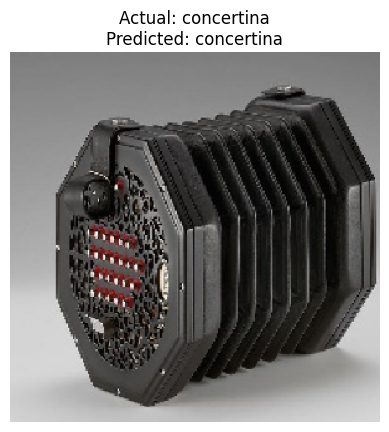

In [52]:
# Test the prediction of the loaded model
test_random_image(loaded_model, test_gen, img_size=IMG_SIZE)
